# Gate calibration with RL with the Quantum Orchestration Platform

This notebook is the template workflow enabling you to run gate calibration leveraging all the low-level capabilities of the QOP for maximum efficiency.

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, Gate
from typing import List
from gymnasium.spaces import Box
from rl_qoc.qua import QMEnvironment, QMConfig, CustomQMPPO
from quam_libs.components import QuAM, Transmon
from qiskit_qm_provider import FluxTunableTransmonBackend, QMInstructionProperties, InputType
from qiskit_qm_provider.backend_utils import add_basic_macros_to_machine
from rl_qoc.agent.ppo_config import (
    WandBConfig,
    PPOConfig,
    TrainingConfig,
    TrainFunctionSettings,
    TotalUpdates,
)
from rl_qoc import (
    RescaleAndClipAction,
    GateTargetConfig,
    ChannelReward,
    StateReward,
    CAFEReward,
    ExecutionConfig,
    QEnvConfig,
    BenchmarkConfig,
)

2025-05-29 18:47:10,419 - qm - INFO     - Starting session: ea7f33fe-72b0-47d7-8ee1-8e97084badde
2025-05-29 18:47:10 INFO Starting session: ea7f33fe-72b0-47d7-8ee1-8e97084badde


£## Accessing the device

In [2]:
machine = QuAM.load()
if not machine.active_qubits[0].macros:
    add_basic_macros_to_machine(machine)
backend = FluxTunableTransmonBackend(machine)
print(backend.target)

Target: Transmon based QuAM
Number of qubits: 5
Instructions:
	x
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	rz
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	sx
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	measure
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	reset
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	delay
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	if_else
	while_loop
	for_loop
	switch_case



/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/qiskit-qm-provider/qiskit_qm_provider/flux_tunable_transmon_backend.py:54: UserWarning: qiskit.pulse is not available, channel mapping will not be set.
  warnings.warn("qiskit.pulse is not available, channel mapping will not be set.")


In [3]:
print("Available qubits: ", backend.qubit_dict)
print("Available qubit pairs: ", backend.qubit_pair_dict)

Available qubits:  {'qC1': 0, 'qC5': 1, 'qD1': 2, 'qD2': 3, 'qD3': 4}
Available qubit pairs:  {}


In [4]:
using_vpn = True
if using_vpn:
    machine.network["cloud"] = False

## Create a custom gate to edit

We add at the Qiskit level the custom gate we want to calibrate, and we then specify the QUA macro in charge of 
implementing the parametrized pulse representation of this template parametrized gate.

In [5]:
def apply_parametrized_circuit(
    qc: QuantumCircuit, params: List[Parameter], q_reg: QuantumRegister, **kwargs
):

    try:
        physical_qubits: List[int] = kwargs["physical_qubits"]
        backend: FluxTunableTransmonBackend = kwargs["backend"]
    except KeyError:
        raise KeyError(
            "Missing one of the required keys for the parametric circuit ('backend' and 'physical_qubits'"
        )
    custom_x = Gate("x_cal", 1, params)
    qc.append(custom_x, [q_reg[0]])

    def qua_macro(amp):
        qubit: Transmon = backend.get_qubit(physical_qubits[0])
        qubit.xy.play("x180", amplitude_scale=amp)

    instruction_prop = QMInstructionProperties(qua_pulse_macro=qua_macro)
    backend.target.add_instruction(custom_x, {tuple(physical_qubits): instruction_prop})
    return qc

## Create Environment configuration

1. Create target instance: Specify which gate you want and on which qubit it should be applied
2. Choose which reward scheme you want. You can choose among three methods that are carefully implemented within the QOP: Direct Channel/State Fidelity Estimation (DFE), and Context-Aware Fidelity Estimation (CAFE)

In [6]:
physical_qubits = (0,)
target_gate = "x"
gate_target = GateTargetConfig(physical_qubits, gate=target_gate)
reward = ChannelReward()

3. Decide which action space to create
4. Decide how the parameters should be passed to the QOP (Choose between Input Stream, DGX Quantum, IO variables)
5. To fix the QUA program duration, we also can pass to the configuration the number of training updates expected (it should be the same variable used when declaring the agent).
6. Set up training hyperparameters on the environment side

In [7]:
# Action space specification
param_bounds = [(-1.98, 2.0)]  # Can be any number of bounds


# Environment execution parameters
seed = 1203  # Master seed to make training reproducible
batch_size = 10  # Number of actions to evaluate per policy evaluation
n_shots = 10  # Minimum number of shots per fiducial evaluation
pauli_sampling = 100  # Number of fiducials to compute for fidelity estimation (DFE only)
n_reps = 1  # Number of repetitions of the cycle circuit
num_updates = TotalUpdates(50)

input_type = InputType.INPUT_STREAM


def create_action_space(param_bounds):
    param_bounds = np.array(param_bounds, dtype=np.float32)
    lower_bound, upper_bound = param_bounds.T
    return Box(low=lower_bound, high=upper_bound, shape=(len(param_bounds),), dtype=np.float32)


action_space = create_action_space(param_bounds)

backend_config = QMConfig(
    parametrized_circuit=apply_parametrized_circuit,
    backend=backend,
    input_type=input_type,
    verbosity=2,
    parametrized_circuit_kwargs={"physical_qubits": physical_qubits, "backend": backend},
    num_updates=TotalUpdates.total_updates,
)
execution_config = ExecutionConfig(
    batch_size=batch_size,
    sampling_paulis=pauli_sampling,
    n_shots=n_shots,
    n_reps=n_reps,
    seed=seed,
    control_flow_enabled=True,
)
q_env_config = QEnvConfig(
    target=gate_target,
    backend_config=backend_config,
    action_space=action_space,
    execution_config=execution_config,
    reward=reward,
    benchmark_config=BenchmarkConfig(0),
)  # No benchmark for now

q_env = QMEnvironment(training_config=q_env_config)
rescaled_env = RescaleAndClipAction(q_env, -1.0, 1.0)

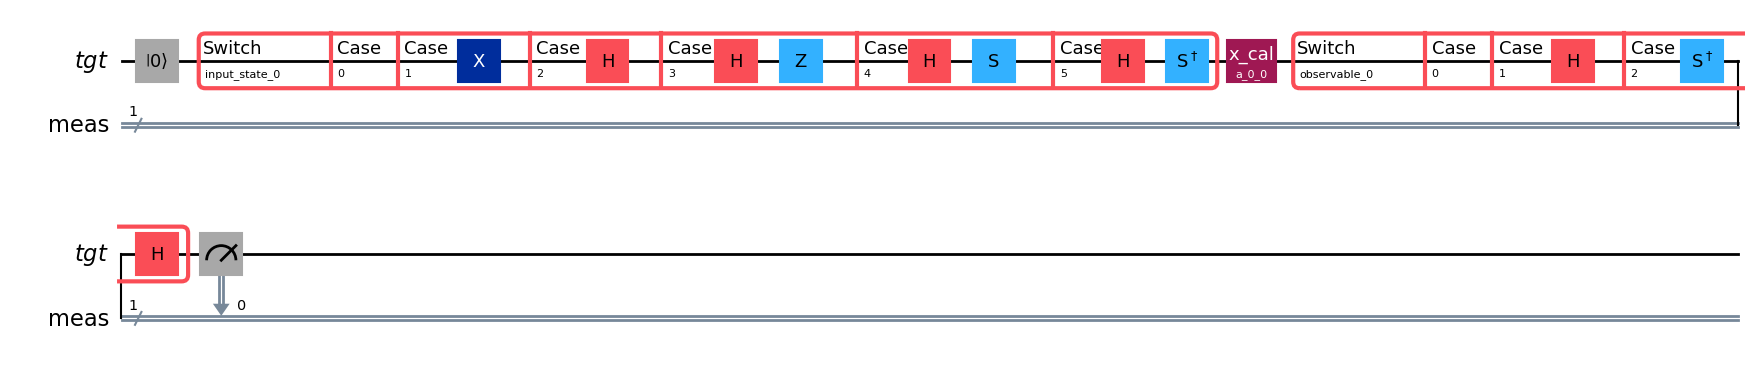

In [8]:
q_env.real_time_circuit.draw("mpl")

In [11]:
ppo_config = PPOConfig.from_yaml("agent_config.yaml")
ppo_agent = CustomQMPPO(ppo_config, rescaled_env)

ppo_training = TrainingConfig(num_updates)
ppo_settings = TrainFunctionSettings(plot_real_time=True, print_debug=True)

In [ ]:
q_env.start_program()